In [ ]:
!pip install gymnasium


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.7 MB/s eta 0:00:00


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import numpy as np
from collections import deque
import tensorflow as tf


class Agent(object):
    def __init__(self, action_size: int, state_size: int):
        self.action_size = action_size
        self.state_size = state_size
        self.learning_rate = 0.001
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.98
        self.epsilon_min = 0.01

        self.relay_buffer = deque(maxlen=50000)

        self.main_neural_network = self.build_nn()
        self.target_neural_network = self.build_nn()

        self.target_neural_network.set_weights(self.main_neural_network.get_weights())

    def build_nn(self):
        with tf.device('/gpu:0'):
          model = Sequential()
          model.add(Dense(32, activation="relu", input_dim=self.state_size))
          model.add(Dense(32, activation="relu"))
          model.add(Dense(self.action_size))
          model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
          return model

    def store_experience(self, state, action, reward, next_state, terminated):
        self.relay_buffer.append((state, action, reward, next_state, terminated))

    def epsilon_greedy(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state = state.reshape((1, self.state_size))
            q_values = self.main_neural_network.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def get_batch(self, batch_size: int):
        training_batch = random.sample(self.relay_buffer, batch_size)
        states = np.array([batch[0] for batch in training_batch]).reshape(batch_size, self.state_size)
        actions = np.array([batch[1] for batch in training_batch])
        rewards = np.array([batch[2] for batch in training_batch])
        next_states = np.array([batch[3] for batch in training_batch]).reshape(batch_size, self.state_size)
        terminateds = np.array([batch[4] for batch in training_batch])
        return states, actions, rewards, next_states, terminateds

    def training(self, batch_size):
        with tf.device('/gpu:0'):
          states, actions, rewards, next_states, terminateds = self.get_batch(batch_size=batch_size)

          q_values = self.main_neural_network.predict(states, verbose=0)
          n_q_values = self.target_neural_network.predict(next_states, verbose=0)
          max_n_q_values = np.amax(n_q_values, axis=1)

          for i in range(batch_size):
              new_q_values = rewards[i] if terminateds[i] else rewards[i] + self.gamma * max_n_q_values[i]
              q_values[i][actions[i]] = new_q_values

          self.main_neural_network.fit(states, q_values)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 8ms/step - loss: 9.2165
Episode 81 reached reward: 315.0
2/2 [==============================] - 0s 6ms/step - loss: 9.2653
Episode 82 reached reward: 289.0
2/2 [==============================] - 0s 10ms/step - loss: 5.3354
Episode 83 reached reward: 211.0
2/2 [==============================] - 0s 12ms/step - loss: 4.5805
Episode 84 reached reward: 230.0
2/2 [==============================] - 0s 19ms/step - loss: 6.8456
Episode 85 reached reward: 216.0
2/2 [==============================] - 0s 8ms/step - loss: 104.4331
Episode 86 reached reward: 236.0
2/2 [==============================] - 0s 7ms/step - loss: 11.4341
Episode 87 reached reward: 297.0
2/2 [==============================] - 0s 7ms/step - loss: 5.2070
Episode 88 reached reward: 282.0
2/2 [==============================] - 0s 11ms/step - loss: 4.7085
Episode 89 reached reward: 281.0
2/2 [==============================] - 0s 7ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


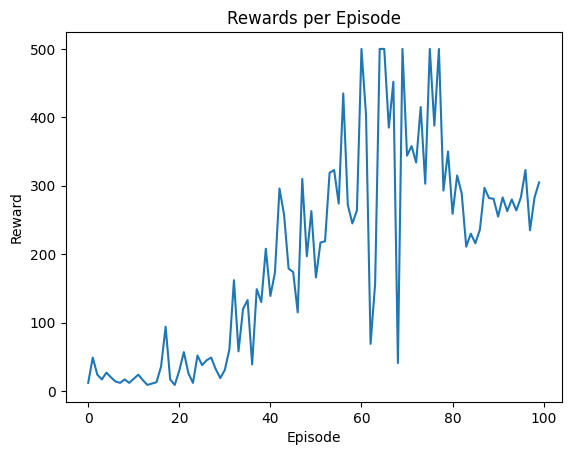

In [ ]:
import gymnasium as gym
import keras
import numpy as np
import matplotlib.pyplot as plt

def train():
    env = gym.make('CartPole-v1')
    env.reset()

    BATCH_SIZE = 64
    UPDATE_WEIGHTS_TIME = 10

    ACTION_SIZE = env.action_space.n
    STATE_SIZE = env.observation_space.shape[0]

    episodes = 100
    units = 500

    agent = Agent(action_size=ACTION_SIZE, state_size=STATE_SIZE)

    episode_rewards = []

    for ep in range(episodes):
        reward_in_episode = 0
        state, _ = env.reset()

        for unit in range(units):

            if unit % UPDATE_WEIGHTS_TIME == 0:
                agent.target_neural_network.set_weights(agent.main_neural_network.get_weights())

            action = agent.epsilon_greedy(state)
            n_state, reward, terminated, truncated, _ = env.step(action)
            reward_in_episode += reward
            agent.store_experience(state, action, reward, n_state, terminated)

            state = n_state

            if terminated:
                print(f"Episode {ep} reached reward: {reward_in_episode}")
                break

            # if truncated:
            #     print(f"Episode {ep}, unit {unit}, reach reward in truncated {reward_in_episode}")
            #     break

            if len(agent.relay_buffer) >= BATCH_SIZE:
                agent.training(batch_size=BATCH_SIZE)

        episode_rewards.append(reward_in_episode)

        if agent.epsilon > agent.epsilon_min:
            agent.epsilon = agent.epsilon * agent.epsilon_decay

    agent.main_neural_network.save("trained_agent.h5")

    # Plotting the rewards
    plt.plot(range(episodes), episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.show()

def inference():
    env = gym.make('CartPole-v1', render_mode="human")
    env.reset()

    state, _ = env.reset()
    state_size = env.observation_space.shape[0]

    my_agent = keras.models.load_model("trained_agent.h5")
    # my_agent = keras.models.load_model("trained_agent_template.h5")
    n_timesteps = 500

    for _ in range(n_timesteps):
        env.render()

        state = state.reshape((1, state_size))
        q_values = my_agent.predict(state, verbose=0)
        max_q_values = np.argmax(q_values)

        next_state, _, _, _, _ = env.step(action=max_q_values)
        state = next_state

if __name__ == '__main__':
    train()
    # inference()
